# **Tutorial 3: Reconstructing Past Changes in Terrestrial Climate**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Brodie Pearson

**Content editors:** Dionessa Biton

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

###**Code and Data Sources**

Code for this tutorial is based on an existing notebook from LinkedEarth that provides instruction on [working with LiPD files](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L1_working_with_LiPD.ipynb). 

Data from the following sources are used in this tutorial:

*   Euro2k database: PAGES2k Consortium., Emile-Geay, J., McKay, N. et al. A global multiproxy database for temperature reconstructions of the Common Era. Sci Data 4, 170088 (2017). https://doi.org/10.1038/sdata.2017.88
















#**Tutorial 3 Objectives**

In this tutorial, we’ll explore the Euro2K proxy network, which is a subset of PAGES2K, the database we explored in the first tutorial. We will specifically focus on intepretting temperature change over the past 2,000 years as recorded by proxy records from tree rings, speleothems, and lake sediments. To analyze these datasets, we will group them by archive and create time series plots to assess temperature variations.

During this tutorial you will:


*   Plot temperature records based on three different terrestrial proxies
*   Assess similarities and differences between the temperature records






In [ ]:
# Install libraries
!pip install pandas
!pip install numpy
!pip install LiPD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.9/996.9 KB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 KB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.4/903.4 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.2 MB/s eta 0:00:00
  Created wheel for LiPD: filename=LiPD-0.2.8.9-py3-none-any.whl size=139967 sha256=eaaa3a852466d7c8487efda0a5a5808833c4988fadbe3258801f6d553f7fc29e
  Stored in directory: /root/.cache/pip/wheels/8a/fa/c8/eb42fde467acb72e60a92c9c5e7bcda20c79c77c3cffff83b3
  Created wheel for demjson3: filename=dem

In [ ]:
!pip install cartopy
!pip install pyleoclim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 41.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.0 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp39-cp39-linux_x86_64.whl size=11113639 sha256=29838cc916641848fd6c09a4b0346ef5cd77d1e2f088aad9c7db69f46760af02
  Stored in directory: /root/.cache/pip/wheels/74/b9/f5/2c94acd7cd21480e6cf63169144d7aac3e8d9cf638225ed578
Successfully built cartopy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     

In [ ]:
# Import libraries
import pyleoclim as pyleo
import pandas as pd
import numpy as np
import lipd

## Loading terrestrial paleoclimate records

First, we need to download the data. Similar to Tutorial 1, the data is stored as a LiPD file, and we will be using Pyleoclim to format and interpret the data.

In [ ]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/Shared drives/Academy/Courses/Climate/Climatematch/02-Curriculum/Climatematch Content Folder/'

In [ ]:
# The LiPD object can be used to load datasets stored in the LiPD format. 
# In this first case study, we will load an entire library of LiPD files:
d_euro = pyleo.Lipd(data_dir+'Euro2k')

Disclaimer: LiPD files may be updated and modified to adhere to standards

Found: 31 LiPD file(s)
reading: Eur-NorthernSpain.Martn-Chivelet.2011.lpd
reading: Eur-LakeSilvaplana.Trachsel.2010.lpd
reading: Ocn-AqabaJordanAQ19.Heiss.1999.lpd
reading: Eur-LakeSilvaplana.Larocque-Tobler.2010.lpd
reading: Eur-TatraMountains.Bntgen.2013.lpd
reading: Ocn-RedSea.Felis.2000.lpd
reading: Eur-NorthernScandinavia.Esper.2012.lpd
reading: Eur-EasternCarpathianMountains.Popa.2008.lpd
reading: Eur-CoastofPortugal.Abrantes.2011.lpd
reading: Arc-PolarUrals.Wilson.2015.lpd
reading: Eur-Tallinn.Tarand.2001.lpd
reading: Eur-Stockholm.Leijonhufvud.2009.lpd
reading: Arc-Indigirka.Hughes.1999.lpd
reading: Arc-Jamtland.Wilson.2016.lpd
reading: Eur-FinnishLakelands.Helama.2014.lpd
reading: Arc-GulfofAlaska.Wilson.2014.lpd
reading: Eur-RAPiD-17-5P.Moffa-Sanchez.2014.lpd
reading: Eur-Seebergsee.Larocque-Tobler.2012.lpd
reading: Arc-Tornetrask.Melvin.2012.lpd
reading: Eur-EuropeanAlps.Bntgen.2011.lpd
reading: Eur-C

In this next cell of code, we will use `Lipd.to_tso` to obtain a list of dictionaries that can be iterated upon. Dictionaries are native to Python and can be easily explored as shown below. The first line of the code creates the list of dictionaries while the for loop goes over each dictionary to lift relevant information that would allow us to identify the relevant dictionary for our work and print it out per index:



In [ ]:
ts_list = d_euro.to_tso()
for idx, item in enumerate(ts_list):
    print(str(idx)+': '+item['dataSetName']+': '+item['paleoData_variableName'])


extracting paleoData...
extracting: Eur-NorthernSpain.Martín-Chivelet.2011
extracting: Eur-LakeSilvaplana.Trachsel.2010
extracting: Ocn-AqabaJordanAQ19.Heiss.1999
extracting: Eur-LakeSilvaplana.Larocque-Tobler.2010
extracting: Eur-TatraMountains.Büntgen.2013
extracting: Ocn-RedSea.Felis.2000
extracting: Eur-NorthernScandinavia.Esper.2012
extracting: Eur-EasternCarpathianMountains.Popa.2008
extracting: Eur-CoastofPortugal.Abrantes.2011
extracting: Arc-PolarUrals.Wilson.2015
extracting: Eur-Tallinn.Tarand.2001
extracting: Eur-Stockholm.Leijonhufvud.2009
extracting: Arc-Indigirka.Hughes.1999
extracting: Arc-Jamtland.Wilson.2016
extracting: Eur-FinnishLakelands.Helama.2014
extracting: Arc-GulfofAlaska.Wilson.2014
extracting: Eur-RAPiD-17-5P.Moffa-Sanchez.2014
extracting: Eur-Seebergsee.Larocque-Tobler.2012
extracting: Arc-Tornetrask.Melvin.2012
extracting: Eur-EuropeanAlps.Büntgen.2011
extracting: Eur-CentralEurope.Dobrovolný.2009
extracting: Arc-Forfjorddalen.McCarroll.2013
extracting: Eu

Once we have our data downloaded and organized, we need to store the data as a `LipdSeriesList`:

In [ ]:
ts_SeriesList = d_euro.to_LipdSeriesList()

extracting paleoData...
extracting: Eur-NorthernSpain.Martín-Chivelet.2011
extracting: Eur-LakeSilvaplana.Trachsel.2010
extracting: Ocn-AqabaJordanAQ19.Heiss.1999
extracting: Eur-LakeSilvaplana.Larocque-Tobler.2010
extracting: Eur-TatraMountains.Büntgen.2013
extracting: Ocn-RedSea.Felis.2000
extracting: Eur-NorthernScandinavia.Esper.2012
extracting: Eur-EasternCarpathianMountains.Popa.2008
extracting: Eur-CoastofPortugal.Abrantes.2011
extracting: Arc-PolarUrals.Wilson.2015
extracting: Eur-Tallinn.Tarand.2001
extracting: Eur-Stockholm.Leijonhufvud.2009
extracting: Arc-Indigirka.Hughes.1999
extracting: Arc-Jamtland.Wilson.2016
extracting: Eur-FinnishLakelands.Helama.2014
extracting: Arc-GulfofAlaska.Wilson.2014
extracting: Eur-RAPiD-17-5P.Moffa-Sanchez.2014
extracting: Eur-Seebergsee.Larocque-Tobler.2012
extracting: Arc-Tornetrask.Melvin.2012
extracting: Eur-EuropeanAlps.Büntgen.2011
extracting: Eur-CentralEurope.Dobrovolný.2009
extracting: Arc-Forfjorddalen.McCarroll.2013
extracting: Eu

/usr/local/lib/python3.9/dist-packages/pyleoclim/core/lipd.py:262: UserWarning: The timeseries from 48: Eur-CentralandEasternPyrenees.Pla.2004: sampleID could not be coerced into a LipdSeries object, passing
  warnings.warn(txt)


In [ ]:
series = pyleo.MultipleSeries(ts_SeriesList)

Next, we can filter all of the data so that we only keep reconstructions from terrestrial archives (tree rings, speleothems and lake sediments).

In [ ]:
def filter_data(dataset, archive_type, variable_name): 
    """
    Return a MultipleSeries object with the variable record (variable_name) for a given archive_type.
    """
    # Create a list of dictionary that can be iterated upon using Lipd.to_tso method
    ts_list = dataset.to_tso()
    # Append the correct indices for a given value of archive_type and variable_name 
    indices = []
    for idx, item in enumerate(ts_list):
        # Check that it is available to avoid errors on the loop
        if 'archiveType' in item.keys(): 
            # If it's a archive_type, then proceed to the next step
            if item['archiveType'] == archive_type: 
                if item['paleoData_variableName'] == variable_name:
                    indices.append(idx)
    print(indices)
    # Create a list of LipdSeries for the given indices
    ts_list_archive_type = []
    for indice in indices:
        ts_list_archive_type.append(pyleo.LipdSeries(ts_list[indice]))
    
    return pyleo.MultipleSeries(ts_list_archive_type)

Let's create a new list that only has temperature reconstructions based on proxies from **lake sediments**:

In [ ]:
ms_euro_lake = filter_data(d_euro, 'lake sediment', 'temperature')

extracting paleoData...
extracting: Eur-NorthernSpain.Martín-Chivelet.2011
extracting: Eur-LakeSilvaplana.Trachsel.2010
extracting: Ocn-AqabaJordanAQ19.Heiss.1999
extracting: Eur-LakeSilvaplana.Larocque-Tobler.2010
extracting: Eur-TatraMountains.Büntgen.2013
extracting: Ocn-RedSea.Felis.2000
extracting: Eur-NorthernScandinavia.Esper.2012
extracting: Eur-EasternCarpathianMountains.Popa.2008
extracting: Eur-CoastofPortugal.Abrantes.2011
extracting: Arc-PolarUrals.Wilson.2015
extracting: Eur-Tallinn.Tarand.2001
extracting: Eur-Stockholm.Leijonhufvud.2009
extracting: Arc-Indigirka.Hughes.1999
extracting: Arc-Jamtland.Wilson.2016
extracting: Eur-FinnishLakelands.Helama.2014
extracting: Arc-GulfofAlaska.Wilson.2014
extracting: Eur-RAPiD-17-5P.Moffa-Sanchez.2014
extracting: Eur-Seebergsee.Larocque-Tobler.2012
extracting: Arc-Tornetrask.Melvin.2012
extracting: Eur-EuropeanAlps.Büntgen.2011
extracting: Eur-CentralEurope.Dobrovolný.2009
extracting: Arc-Forfjorddalen.McCarroll.2013
extracting: Eu

Let's create a new list that only has temperature reconstructions based on proxies from **tree rings**:

In [ ]:
ms_euro_tree = filter_data(d_euro, 'tree', 'temperature')

extracting paleoData...
extracting: Eur-NorthernSpain.Martín-Chivelet.2011
extracting: Eur-LakeSilvaplana.Trachsel.2010
extracting: Ocn-AqabaJordanAQ19.Heiss.1999
extracting: Eur-LakeSilvaplana.Larocque-Tobler.2010
extracting: Eur-TatraMountains.Büntgen.2013
extracting: Ocn-RedSea.Felis.2000
extracting: Eur-NorthernScandinavia.Esper.2012
extracting: Eur-EasternCarpathianMountains.Popa.2008
extracting: Eur-CoastofPortugal.Abrantes.2011
extracting: Arc-PolarUrals.Wilson.2015
extracting: Eur-Tallinn.Tarand.2001
extracting: Eur-Stockholm.Leijonhufvud.2009
extracting: Arc-Indigirka.Hughes.1999
extracting: Arc-Jamtland.Wilson.2016
extracting: Eur-FinnishLakelands.Helama.2014
extracting: Arc-GulfofAlaska.Wilson.2014
extracting: Eur-RAPiD-17-5P.Moffa-Sanchez.2014
extracting: Eur-Seebergsee.Larocque-Tobler.2012
extracting: Arc-Tornetrask.Melvin.2012
extracting: Eur-EuropeanAlps.Büntgen.2011
extracting: Eur-CentralEurope.Dobrovolný.2009
extracting: Arc-Forfjorddalen.McCarroll.2013
extracting: Eu

Let's create a new list that only has temperature reconstructions based on proxies from **speleothems**:

In [ ]:
ms_euro_spel = filter_data(d_euro, 'speleothem', 'd18O')

extracting paleoData...
extracting: Eur-NorthernSpain.Martín-Chivelet.2011
extracting: Eur-LakeSilvaplana.Trachsel.2010
extracting: Ocn-AqabaJordanAQ19.Heiss.1999
extracting: Eur-LakeSilvaplana.Larocque-Tobler.2010
extracting: Eur-TatraMountains.Büntgen.2013
extracting: Ocn-RedSea.Felis.2000
extracting: Eur-NorthernScandinavia.Esper.2012
extracting: Eur-EasternCarpathianMountains.Popa.2008
extracting: Eur-CoastofPortugal.Abrantes.2011
extracting: Arc-PolarUrals.Wilson.2015
extracting: Eur-Tallinn.Tarand.2001
extracting: Eur-Stockholm.Leijonhufvud.2009
extracting: Arc-Indigirka.Hughes.1999
extracting: Arc-Jamtland.Wilson.2016
extracting: Eur-FinnishLakelands.Helama.2014
extracting: Arc-GulfofAlaska.Wilson.2014
extracting: Eur-RAPiD-17-5P.Moffa-Sanchez.2014
extracting: Eur-Seebergsee.Larocque-Tobler.2012
extracting: Arc-Tornetrask.Melvin.2012
extracting: Eur-EuropeanAlps.Büntgen.2011
extracting: Eur-CentralEurope.Dobrovolný.2009
extracting: Arc-Forfjorddalen.McCarroll.2013
extracting: Eu

Since we are going to compare temperature datasets based on different terrestrial climate archives (lake sediments, tree rings and speleothems), it's helpful to standardize the data since there are multiple proxy types in this subset of data:

In [ ]:
#Standardize the data
spel_stnd = ms_euro_spel.standardize()
lake_stnd = ms_euro_lake.standardize()
tree_stnd = ms_euro_tree.standardize()

Now we can use Pyleoclim functions to create three stacked plots of this data with lake sediment records on top, tree ring reconstructions in the middle and speleothem records on the bottom:

(<Figure size 900x500 with 3 Axes>,
 {0: <Axes: ylabel='d18O [permil]'>,
  1: <Axes: ylabel='d18O [permil]'>,
  2: <Axes: xlabel='Year [AD]'>})

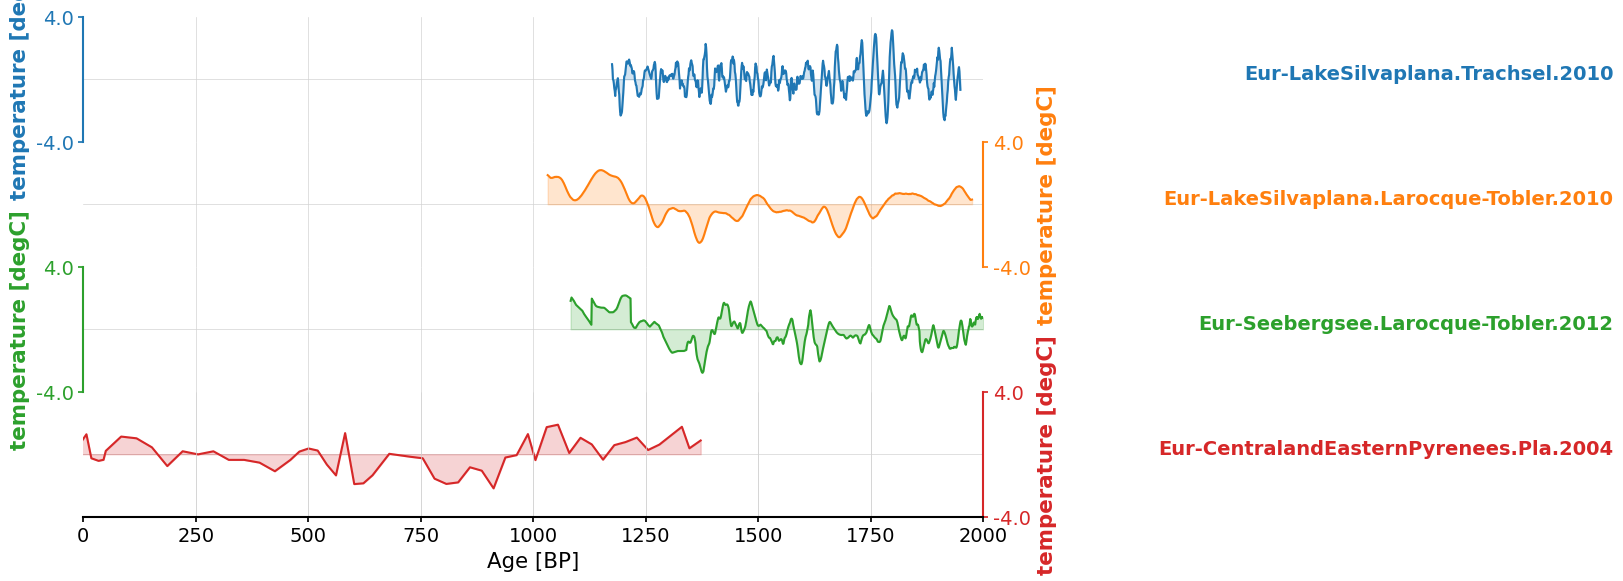

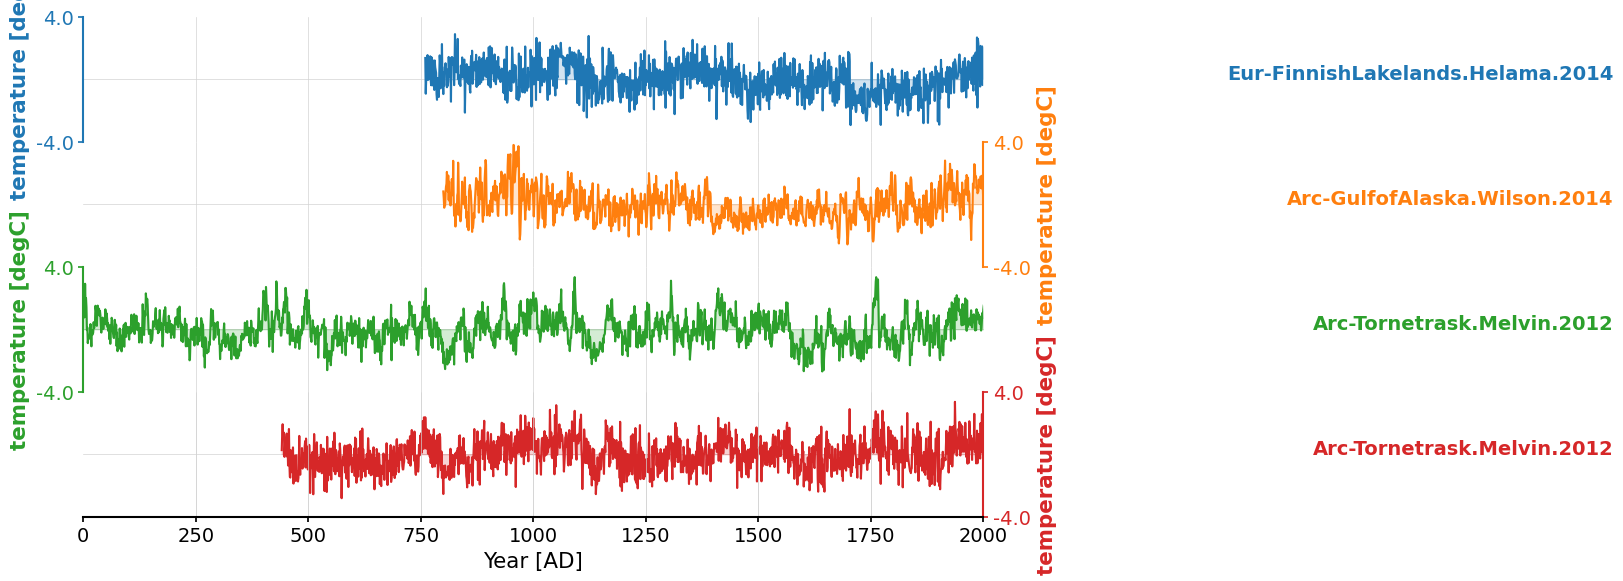

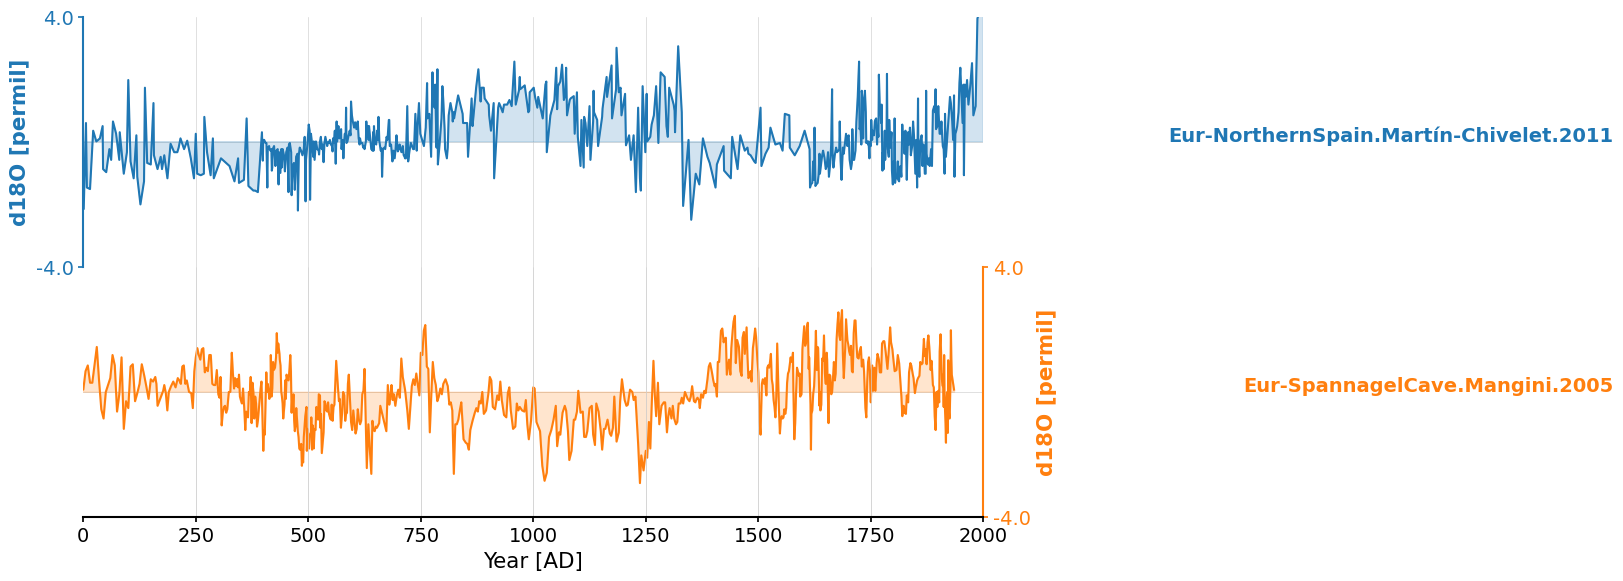

In [ ]:
lake_stnd.stackplot(label_x_loc=1.7,xlim=[0,2000],v_shift_factor =1,figsize=[9,5])
tree_stnd.stackplot(label_x_loc=1.7,xlim=[0,2000],v_shift_factor =1,figsize=[9,5]) 
spel_stnd.stackplot(label_x_loc=1.7,xlim=[0,2000],v_shift_factor =1,figsize=[9,5]) 


Let's make some inferences about the temperature data over the past 2,000 years:


*   Do all of the reconstructions record the same patterns? 
*   Do the temperature records based on the same proxy record similar patterns?
*   What is the long term temperature trend during this period of time?
*   What might be causing the more frequent variations in temperature?



